In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pycountry

Data Preparation

In [3]:
#Import Training Data - Change file path to match file location
df = pd.read_excel("Kickstarter.xlsx")


#Function to convert country codes to country name using pycountry library - for easier interpretation
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return "Unknown"


#Function for Pre-Processing Data for Clustering Tasks


#1. Drop Columns that have no impact on prediction
df = df.drop(columns=['id','name'], axis=1)

#2. Drop Columns related to state change duration - keeping only launch_to_state_change_days
cols_not_reqd = ['state_changed_at',
                'state_changed_at_weekday', 'state_changed_at_month',
                'state_changed_at_day', 'state_changed_at_yr',
                'state_changed_at_hr', 'launch_to_state_change_days']

df = df.drop(columns=cols_not_reqd, axis=1)

#3. Drop Columns with repeated information in other columns:
cols_repeat_info = ['currency', 'deadline', 'created_at', 'launched_at', 'pledged']
df = df.drop(columns=cols_repeat_info, axis=1)

#4. Remove rows with state other than successful or failed
df = df[df['state'].isin(['successful', 'failed'])]
df['state'] = df['state'].apply(lambda x: 1 if x=='successful' else 0)

#5. Create new column to convert goal to USD and drop goal, rate column
df['goal_usd'] = df['goal'] * df['static_usd_rate']
df = df.drop(columns=['goal', 'static_usd_rate'], axis=1)

#6. Convert country to full name for easier interpretation
df['country'] = df['country'].apply(lambda x: get_country_name(x))

# Pre-processing Steps added after EDA

#7. Replace missing values in category column with Others (assuming these projects were not assigned a category)
df['category'] = df['category'].fillna('Others')

#8. Remove disable_communication column as it has only 1 value, so cannot contribute to prediction
df = df.drop(columns=['disable_communication'], axis=1)

#9. Keep only 1 column each for name_len and blurb_len - keeping name_len_clean and blurb_len as they have higher feature importance
corr_cols_remove = ['name_len','blurb_len_clean']
df = df.drop(columns=corr_cols_remove, axis=1)

#10. Remove created date related columns and keep only create_to_launch_days since it captures the required information. Also, it has low feature importance scores
created_date_cols_remove = ['created_at_weekday', 'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr']
df = df.drop(columns=created_date_cols_remove, axis=1)

#11. Remove year, hour and day columns
year_cols_remove = ['deadline_yr', 'launched_at_yr', 'deadline_hr', 'launched_at_hr', 'deadline_day', 'launched_at_day']
df = df.drop(columns=year_cols_remove, axis=1)

#12. Categorize countries into US and Non-US
df['country'] = df['country'].apply(lambda x: 'US' if x=='United States' else 'Non-US')

#13. Categorize weekday columns into weekday and weekend
weekday_cols = ['deadline_weekday', 'launched_at_weekday']
def map_to_weekend_weekday(x):
    return 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday'
df[weekday_cols] = df[weekday_cols].applymap(map_to_weekend_weekday)


#14. Remove category column also because we dont want to cluster based on categories and get insights
df = df.drop(columns=['category'], axis=1)

#15. Other columns to remove
cols_remove_others = ['backers_count', 'usd_pledged',
                    'spotlight', 'staff_pick']
df = df.drop(columns=cols_remove_others, axis=1)

#14. Dummify categorical columns
categorical_cols = ['country', 'deadline_weekday', 'launched_at_weekday']
#categorical_cols = ['country', 'deadline_weekday', 'launched_at_weekday', 'spotlight', 'staff_pick']
df_wdummies = pd.get_dummies(df, columns=categorical_cols)

In [4]:
# Standardizing using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_wdummies_scaled = scaler.fit_transform(df_wdummies)
df_wdummies_scaled = pd.DataFrame(df_wdummies_scaled, columns=df_wdummies.columns)

Elbow Plot to check optimal no of clusters

Text(0, 0.5, 'Inertia measure')

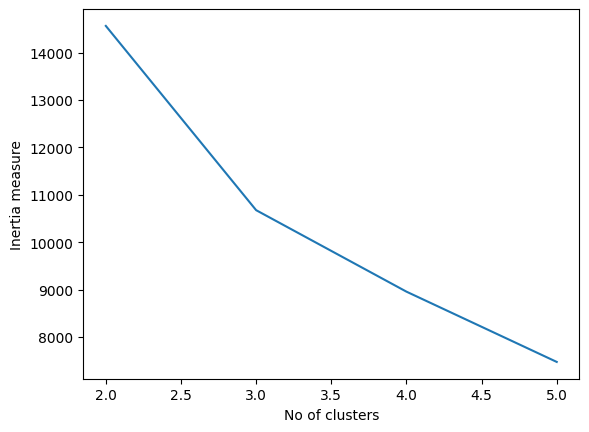

In [5]:
# Calculate inertia for each value of k
from sklearn.cluster import KMeans
withinss = []
for i in range (2,6):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(df_wdummies_scaled)
    withinss.append(model.inertia_)

# Create a plot
from matplotlib import pyplot
pyplot.plot([2,3,4,5],withinss)
pyplot.xlabel("No of clusters")
pyplot.ylabel("Inertia measure")

Silhouette Score

In [6]:
from sklearn.metrics import silhouette_score

# Finding optimal K
for i in range (2,6):    
    kmeans = KMeans(n_clusters=i, random_state=700)
    model = kmeans.fit(df_wdummies_scaled)
    labels = model.labels_
    print(i,':',silhouette_score(df_wdummies_scaled,labels))

2 : 0.31950185580322427
3 : 0.3630320048876496
4 : 0.4078261419932098
5 : 0.38772363775977287


Pseudo F-staistic

In [26]:
# Calculate F-score
from sklearn.metrics import calinski_harabasz_score
from scipy.stats import f

# Finding optimal K
for i in range (2,6):    
    df1=i-1
    df2=len(df_wdummies_scaled)-i
    kmeans = KMeans(n_clusters=i, random_state=700)
    model = kmeans.fit(df_wdummies_scaled)
    labels = model.labels_
    score = calinski_harabasz_score(df_wdummies_scaled, labels)
    print(i,'F-score:',score)
    print(i,'p-value:',1-f.cdf(score, df1, df2))

2 F-score: 5179.557230946053
2 p-value: 1.1102230246251565e-16
3 F-score: 5977.252690856743
3 p-value: 1.1102230246251565e-16
4 F-score: 5484.690216223878
4 p-value: 1.1102230246251565e-16
5 F-score: 5705.733271693603
5 p-value: 1.1102230246251565e-16


Printing Cluster Centers

In [7]:
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(df_wdummies_scaled)
labels = model.predict(df_wdummies_scaled)


cluster_centers = pd.DataFrame(data=model.cluster_centers_, columns=df_wdummies.columns)

cluster_centers.to_excel('ClusterCenters_Kickstarter.xlsx')

#Printing cluster differences from average

# Calculate average values for features across the dataset
average_values = df_wdummies_scaled.mean()

# Convert cluster centers to a DataFrame
cluster_centers = pd.DataFrame(data=model.cluster_centers_, columns=df_wdummies.columns)

# Calculate the difference between cluster centers and average values
difference_from_average = cluster_centers.sub(average_values)

# Write to Excel
difference_from_average.to_excel('ClusterDifferenceFromAverage_Kickstarter.xlsx')

Count of Observations in Each Cluster

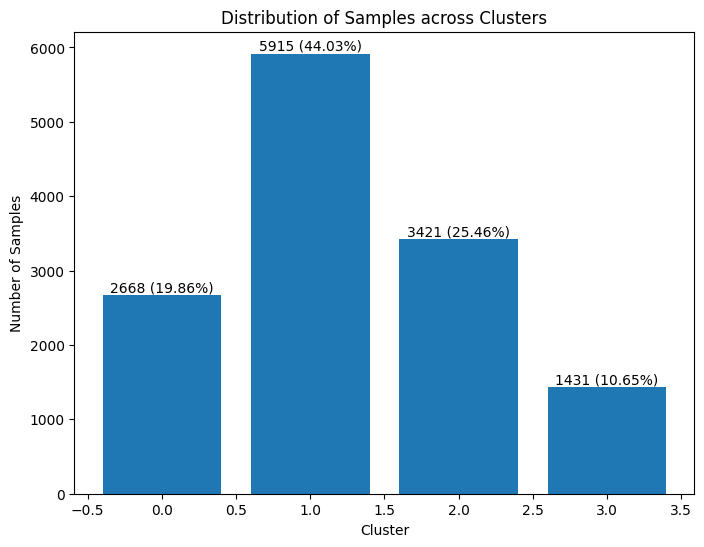

In [14]:
import matplotlib.pyplot as plt
import numpy as np

cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(np.arange(len(cluster_counts)), cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples across Clusters')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{cluster_counts[i]} ({round(100 * cluster_counts[i] / len(labels), 2)}%)',
             ha='center', va='bottom')

plt.show()

In [15]:
# Calculate mean feature values for each cluster
cluster_means = df_wdummies_scaled.groupby(labels).mean()

# Calculate difference from global average for feature importance
difference_from_average = cluster_means.sub(df_wdummies_scaled.mean())

# Identify features with the largest absolute differences
top_features = difference_from_average.abs().mean(axis=0).nlargest(10)
print("Top 10 Features Contributing to Cluster Differences:")
print(top_features)

Top 10 Features Contributing to Cluster Differences:
country_Non-US                 0.321803
country_US                     0.321803
launched_at_weekday_Weekday    0.303256
launched_at_weekday_Weekend    0.303256
deadline_weekday_Weekday       0.291725
deadline_weekday_Weekend       0.291725
state                          0.032190
deadline_month                 0.011217
launched_at_month              0.008536
launch_to_deadline_days        0.007720
dtype: float64


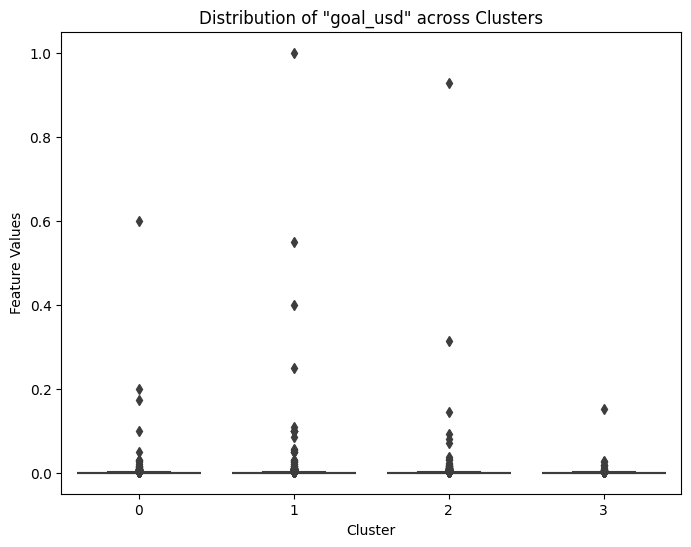

In [18]:
import seaborn as sns
# Choose a feature for boxplot visualization
feature_of_interest = 'goal_usd'

# Create boxplots for the chosen feature across clusters
plt.figure(figsize=(8, 6))
sns.boxplot(x=labels, y=df_wdummies_scaled[feature_of_interest])
plt.xlabel('Cluster')
plt.ylabel('Feature Values')
plt.title(f'Distribution of "{feature_of_interest}" across Clusters')
plt.show()


PCA Output

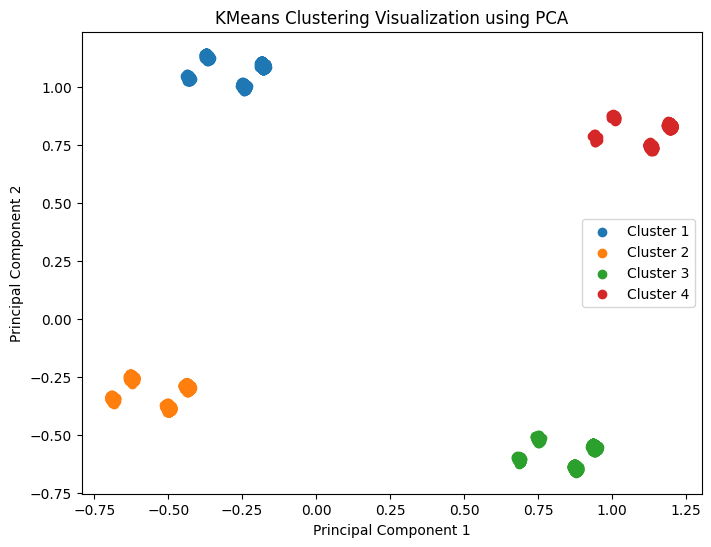

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Perform KMeans clustering (adjust number of clusters as needed)
kmeans = KMeans(n_clusters=4, random_state=700)
clusters = kmeans.fit_predict(df_wdummies_scaled)

# Apply PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_wdummies_scaled)

# Visualize clusters using PCA reduced data
plt.figure(figsize=(8, 6))
for cluster in set(clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster+1}')

plt.title('KMeans Clustering Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [20]:
# Access PCA components and feature loadings
pca_components = pca.components_
feature_names = df_wdummies.columns

# Get the top contributing features for PCA1 and PCA2
top_features_pca1 = [(feature_names[i], pca_components[0, i]) for i in pca_components[0].argsort()[::-1][:5]]
top_features_pca2 = [(feature_names[i], pca_components[1, i]) for i in pca_components[1].argsort()[::-1][:5]]

print("Top contributing features to PCA1:")
print(top_features_pca1)
print("\nTop contributing features to PCA2:")
print(top_features_pca2)


Top contributing features to PCA1:
[('deadline_weekday_Weekend', 0.6874796848924026), ('country_Non-US', 0.12758686864692179), ('launched_at_weekday_Weekday', 0.09415391842481803), ('launch_to_deadline_days', 0.01412151304859717), ('blurb_len', 0.0016621671510280026)]

Top contributing features to PCA2:
[('country_Non-US', 0.6917164712483663), ('deadline_weekday_Weekday', 0.129888494668378), ('launched_at_weekday_Weekend', 0.018749944859138463), ('deadline_month', 0.01338939176594497), ('launched_at_month', 0.011927548174442682)]


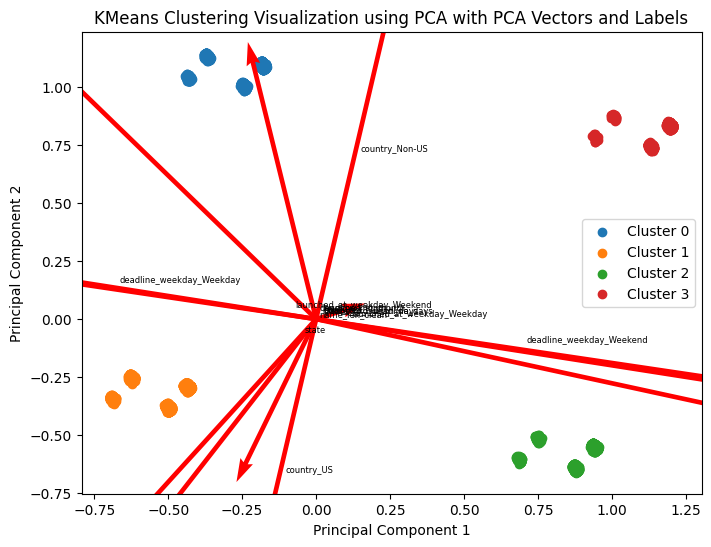

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Perform KMeans clustering (adjust number of clusters as needed)
kmeans = KMeans(n_clusters=4, random_state=700)
clusters = kmeans.fit_predict(df_wdummies_scaled)

# Apply PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_wdummies_scaled)

# Visualize clusters using PCA reduced data
plt.figure(figsize=(8, 6))

# Plot clusters
for cluster in set(clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster}')

# Get PCA components and feature loadings
pca_components = pca.components_

# Plot PCA vectors and label them with feature names
for i, (x, y) in enumerate(zip(pca_components[0, :], pca_components[1, :])):
    plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=0.01, color='r', linewidth=0.05)
    plt.annotate(df_wdummies.columns[i], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=6)

plt.title('KMeans Clustering Visualization using PCA with PCA Vectors and Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
